# VL12: Abschluss

### Set-Up

In [8]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version


path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")

Anzahl Zeilen: 1296675
Anzahl Spalten: 24


# Benfordsches Gesetz

Zum Abschluss testeten wir nach der Vorlesung 12 noch unsere beiden Spalten "amt" (-> Transaktionsbeträge) sowie "city_pop" (-> Einwohnerzahlen) mit dem Benfordschen Gesetz, um zu überprüfen, ob die führenden Ziffern der natürlichen Benfordschen Verteilung folgen oder nicht, was uns Hinweise auf einen möglichen Fraud in diesen Zahlen geben würde. Dabei haben wir nach dem Vergleich der Verteilung einen Chi-Quadrat-Test als quantiativen Fraud-Indikator genutzt.

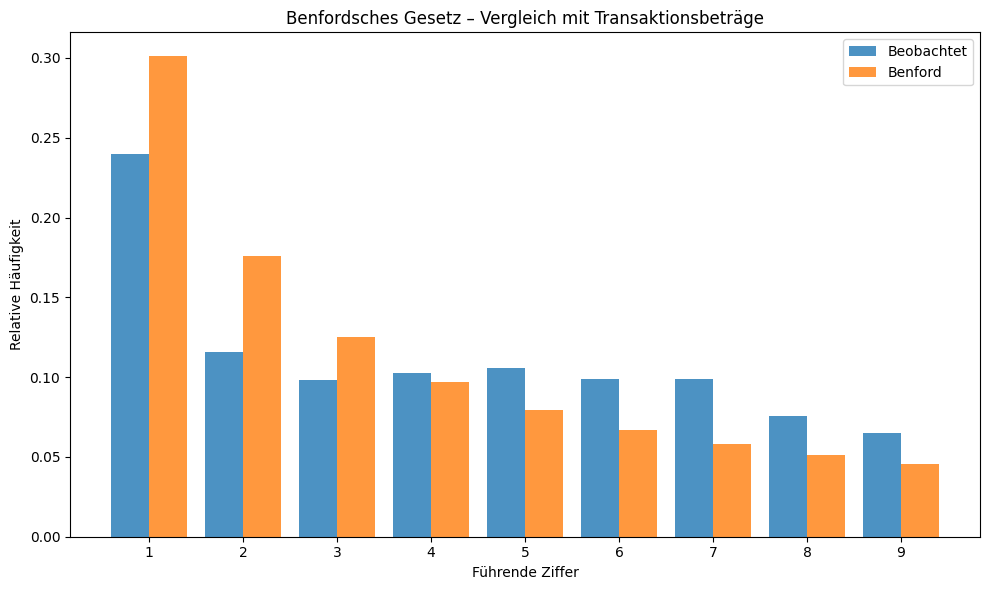

=== Transaktionsbeträge ===
Chi-Quadrat-Statistik: 0.1109
P-Wert: 1.0000
-> Keine signifikante Abweichung von Benford


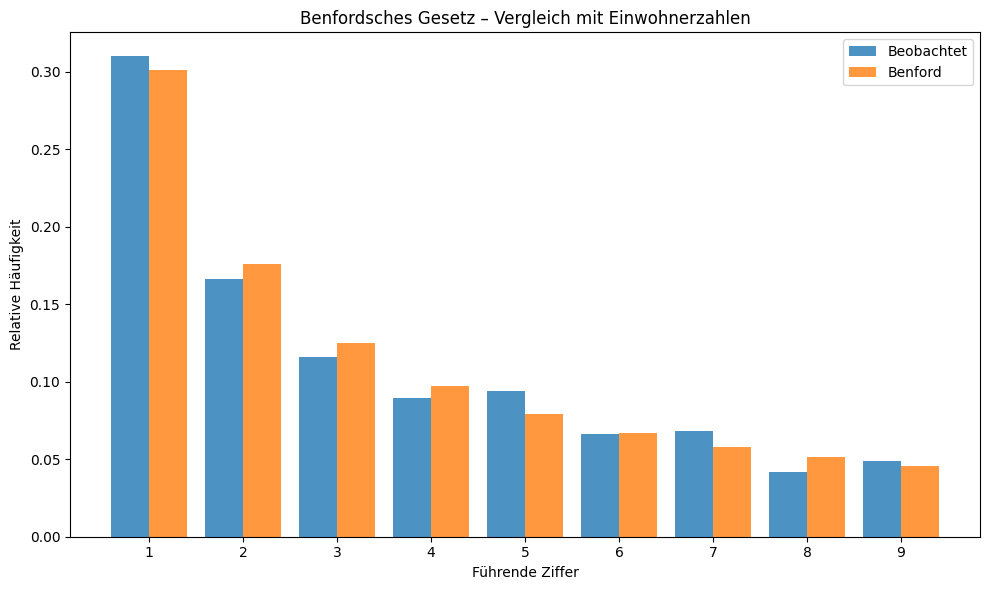

=== Einwohnerzahlen ===
Chi-Quadrat-Statistik: 0.0085
P-Wert: 1.0000
-> Keine signifikante Abweichung von Benford


In [9]:
from scipy.stats import chisquare

amounts = ds['amt']
city_populations = ds["city_pop"]

# Führende Ziffer extrahieren
def leading_digit(x):
    x = abs(x)
    if x == 0 or pd.isna(x):
        return np.nan
    return int(str(x).lstrip('0.')[0])

amt_digits = amounts.apply(leading_digit).dropna()
city_pop_digits = city_populations.apply(leading_digit).dropna()

digits = {"Transaktionsbeträge" : amt_digits, "Einwohnerzahlen" : city_pop_digits }

# Empirische Häufigkeiten berechnen

for name, digit in digits.items():
    observed_counts = digit.value_counts().sort_index()
    observed_freq = observed_counts / observed_counts.sum()

    # Sicherstellen, dass alle Ziffern 1–9 enthalten sind
    observed_freq = observed_freq.reindex(range(1, 10), fill_value=0)

    # Benford-Verteilung
    benford_freq = pd.Series(
        {d: np.log10(1 + 1/d) for d in range(1, 10)}
    )

    # Plot
    plt.figure(figsize=(10, 6))

    plt.bar(
        observed_freq.index - 0.2,
        observed_freq.values,
        width=0.4,
        label="Beobachtet",
        alpha=0.8
    )

    plt.bar(
        benford_freq.index + 0.2,
        benford_freq.values,
        width=0.4,
        label="Benford",
        alpha=0.8
    )

    plt.xlabel("Führende Ziffer")
    plt.ylabel("Relative Häufigkeit")
    plt.title(f"Benfordsches Gesetz – Vergleich mit {name}")
    plt.xticks(range(1, 10))
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Chi-Quadrat-Test
    chi_stat, p_value = chisquare(
        observed_freq.values,
        benford_freq.values
    )

    print(f"=== {name} ===")
    print(f"Chi-Quadrat-Statistik: {chi_stat:.4f}")
    print(f"P-Wert: {p_value:.4f}")

    if p_value < 0.05:
        print(f"-> Signifikante Abweichung von Benford (möglicher Fraud)")
    else:
        print(f"-> Keine signifikante Abweichung von Benford")